# Faster R-CNN Approach

## Faster R-CNN

### Import Libraries

In [ ]:
# Nedded Libraries

# PyTorch
import torch 
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn
import albumentations as A

# Image processing
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

# Image Plots
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Data managements
import numpy as np
import pandas as pd

# File interpretation
import os
import xml.etree.ElementTree as ET
import random

# Others
import time
from collections import Counter
from random import seed, randint
from datetime import datetime

### Find Annotation Files

Indicate the path for the annotation files.

In [ ]:
# Annotations directory path
ann_directory = '/content/FaceMaskDetection/annotations'

# List directory
ann_files = os.listdir(ann_directory)

### Find Image Files

Indicate the path for the image files.

In [ ]:
# Image directory path
img_directory = '/content/FaceMaskDetection/images'

# List directory
img_files = os.listdir(img_directory)

### Find Annotation Files

Indicate the path for the annotation files.

### Helper Functions

This are auxiliary functions used throughout the notebook. This way the notebook stays tidy and clean.

In [ ]:
def draw_bounding_boxes(img_tensor, target=None, prediction=None):
    """Draws bounding boxes in given images. Displays them

        Inputs:
          img:
            Image in tensor format.
          target:
            target dictionary containing bboxes list wit format -> [xmin, ymin, xmax, ymax]

        Returns:
          None
        """

    img = torchvision.transforms.ToPILImage()(img_tensor)

    # fetching the dimensions
    wid, hgt = img.size
    print(str(wid) + "x" + str(hgt))

    # Img to draw in
    draw = ImageDraw.Draw(img)

    if target:
        target_bboxes = target['boxes'].numpy().tolist()
        target_labels = decode_labels(target['labels'].numpy())

        for i in range(len(target_bboxes)):
            # Create Rectangle patches and add the patches to the axes
            draw.rectangle(target_bboxes[i], fill=None, outline='green', width=2)
            draw.text(target_bboxes[i][:2], target_labels[i], fill='green', font=None, anchor=None, spacing=4,
                      align='left', direction=None, features=None, language=None, stroke_width=0, stroke_fill=None,
                      embedded_color=False)

    if prediction:
        prediction_bboxes = prediction['boxes'].detach().cpu().numpy().tolist()
        prediction_labels = decode_labels(prediction['labels'].detach().cpu().numpy())
        for i in range(len(prediction_bboxes)):
            # Create Rectangle patches and add the patches to the axes
            draw.rectangle(prediction_bboxes[i], fill=None, outline='red', width=2)
            draw.text(prediction_bboxes[i][:2], prediction_labels[i], fill='red', font=None, anchor=None, spacing=4,
                      align='left', direction=None, features=None, language=None, stroke_width=0, stroke_fill=None,
                      embedded_color=False)

    display(img)


In [ ]:
def encoded_labels(lst_labels):
    """Encodes label classes from string to integers.

        Labels are encoded accordingly:
            - background => 0
            - with_mask => 1
            - mask_weared_incorrect => 2
            - without_mask => 3

            Args:
              lst_labels:
                A list with classes in string format (e.g. ['with_mask', 'mask_weared_incorrect'...]).

            Returns:
              encoded:
                A list with integers that represent each class.
            """

    encoded=[]
    for label in lst_labels:
        if label == "with_mask":
            code = 1
        elif label == "mask_weared_incorrect":
            code = 2
        elif label == "without_mask":
            code = 3
        else:
            code = 0
        encoded.append(code)
    return encoded

In [ ]:
def decode_labels(lst_labels):
    """
    Decode label classes from integers to strings.
    Labels are encoded accordingly:
        - background => 0
        - with_mask => 1
        - mask_weared_incorrect => 2
        - without_mask => 3

    Args:
      lst_labels:
        A list with classes in integer format (e.g. [1, 2, ...]).

    Returns:
        A list with strings that represent each class.
    """

    labels=[]
    for code in lst_labels:
        if code == 1:
            label = "with_mask"
        elif code == 2:
            label = "mask_weared_incorrect"
        elif code == 3:
            label = "without_mask"
        else:
            label = 'background'
        labels.append(label)
    return labels

In [ ]:
def build_model(nclasses):
    """
    Builds model. Uses Faster R-CNN pre-trained on COCO dataset.

    Args:
      nclasses:
        number of classes

    Return:
      model: Faster R-CNN pre-trained model
    """
    # load pre-trained model on COCO
    model = fasterrcnn_resnet50_fpn(pretrained=True, min_size=400, max_size=700)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, nclasses)

    return model

In [ ]:
def train_model(model, loader, optimizer, scheduler, epochs, device):
  """ 
    Inputs:
      - model
      - loader: Dataloader PyTorch object with training data
      - optimizer
      - scheduler
      - epochs
      - device

    Returns:
      - model
      - loss_list: list with mean loss per epoch. Epoch 1 is in idex 0.
    """
  # Create a loss list to keep epoch average loss
  loss_list = []
  # Epochs
  for epoch in range(epochs):
      print('Starting epoch...... {}/{} '.format(epoch + 1, epochs))
      iteration = 0
      loss_sub_list = []
      start = time.time()
      for images, targets in loader:
          # Agregate images in batch loader
          images = list(image.to(device) for image in images)

          # Agregate targets in batch loader
          targets = [{key: val.to(device) for key, val in target.items()} for target in targets]

          # Sets model to train mode (just a flag)
          model.train()

          # Output of model returns loss and detections
          optimizer.zero_grad()
          output = model(images, targets)

          # Calculate Cost
          losses = sum(loss for loss in output.values())
          loss_value = losses.item()
          loss_sub_list.append(loss_value)
          print('')

          # Update optimizer and learning rate
          losses.backward()
          optimizer.step()
          iteration += 1
          print('Iteration: {:d} --> Loss: {:.3f}'.format(iteration, loss_value))
          
      end = time.time()
      # update scheduler
      scheduler.step()
      # print the loss of epoch
      epoch_loss = np.mean(loss_sub_list)
      loss_list.append(epoch_loss)
      print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end - start))
      
  return model, loss_list

In [ ]:
def apply_nms(orig_prediction, iou_thresh):
    """
    Applies non max supression and eliminates low score bounding boxes.

      Args:
        orig_prediction: the model output. A dictionary containing element scores and boxes.
        iou_thresh: Intersection over Union threshold. Every bbox prediction with an IoU greater than this value
                      gets deleted in NMS.

      Returns:
        final_prediction: Resulting prediction
    """

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    # Keep indices from nms
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

In [ ]:
def remove_low_score_bb(orig_prediction, score_thresh):
    """
    Eliminates low score bounding boxes.

    Args:
        orig_prediction: the model output. A dictionary containing element scores and boxes.
        score_thresh: Boxes with a lower confidence score than this value get deleted

    Returns:
        final_prediction: Resulting prediction
    """

    # Remove low confidence scores according to given threshold
    index_list_scores = []
    scores = orig_prediction['scores'].detach().cpu().numpy()
    for i in range(len(scores)):
        if scores[i] > score_thresh:
            index_list_scores.append(i)
    keep = torch.tensor(index_list_scores)

    # Keep indices from high score bb
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

In [ ]:
def collate_fn(batch):
    # Collate function for Dataloader
    return tuple(zip(*batch))

In [ ]:
def IOU(box1, box2):
    '''
    Intersection over Union - IoU
    *------------
    |   (x2min,y2min)
    |   *----------
    |   | ######| |
    ----|------* (x1max,y1max)
        |         |
        ----------

    Args:
        box1: [xmin,ymin,xmax,ymax]
        box2: [xmin,ymin,xmax,ymax]

    Returns:
        iou -> value of intersection over union of the 2 boxes

    '''

    # Compute coordinates of intersection
    xmin_inter = max(box1[0], box2[0])
    ymin_inter = max(box1[1], box2[1])
    xmax_inter = min(box1[2], box2[2])
    ymax_inter = min(box1[3], box2[3])

    # calculate area of intersection rectangle
    inter_area = max(0, xmax_inter - xmin_inter + 1) * max(0, ymax_inter - ymin_inter + 1) # FIXME why plus one?
 
    # calculate boxes areas
    area1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
 
    # compute IoU
    iou = inter_area / float(area1 + area2 - inter_area)
    assert iou >= 0
    return iou


In [ ]:
def compute_AP(ground_truth, predictions, iou_thresh=0.5, n_classes=4):
    """
    Calculates Average Precision across all classes.

    Args:
        ground_truth: list with ground-truth objects. Needs to have the following format: [sequence, frame, obj, [xmin, ymin, xmax, ymax], label, score]
        predictions: list with predictions objects. Needs to have the following format: [sequence, frame, obj, [xmin, ymin, xmax, ymax], label, score]
        iou_thresh: IoU to which a prediction compared to a ground-truth is considered right.
        n_classes: number of existent classes

    Returns:
        Average precision for the specified threshold.
    """
    # Initialize lists
    APs = []
    class_gt = []
    class_predictions = []

    # AP is computed for each class
    for c in range(n_classes):
        # Find gt and predictions of the class
        for gt in ground_truth:
            if gt[4] == c:
                class_gt.append(gt)
        for predict in predictions:
            if predict[4] == c:
                class_predictions.append(predict)

        # Create dict with array of zeros for bb in each image
        gt_amount_bb = Counter([gt[1] for gt in class_gt])
        for key, val in gt_amount_bb.items():
            gt_amount_bb[key] = np.zeros(val)

        # Sort class predictions by their score
        class_predictions = sorted(class_predictions, key=lambda x: x[5], reverse=True)

        # Create arrays for Positives (True and False)
        TP = np.zeros(len(class_predictions))
        FP = np.zeros(len(class_predictions))
        # Number of true boxes
        truth = len(class_gt)

        # Initializing aux variables
        epsilon = 1e-6

        # Iterate over predictions in each image and compare with ground truth
        for predict_idx, prediction in enumerate(class_predictions):
            # Filter prediction image ground truths
            image_gt = [obj for obj in class_gt if obj[1] == prediction[1]]

            # Initializing aux variables
            best_iou = -1
            best_gt_iou_idx = -1

            # Iterate through image ground truths and calculate IoUs
            for gt_idx, gt in enumerate(image_gt):
                iou = IOU(prediction[3], gt[3])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_iou_idx = gt_idx

            # If the best IoU is greater that thresh than an TP prediction has been found
            if best_iou > iou_thresh and best_gt_iou_idx > -1:
                # Check if gt box was already covered
                if  gt_amount_bb[prediction[1]][best_gt_iou_idx] == 0:
                    gt_amount_bb[prediction[1]][best_gt_iou_idx] = 1  # set as covered
                    TP[predict_idx] = 1  # Count as true positive
                else:
                    FP[predict_idx] = 1
            else:
                FP[predict_idx] = 1

        # Calculate recall and precision
        TP_cumsum = np.cumsum(TP)
        FP_cumsum = np.cumsum(FP)
        recall = np.append([0], TP_cumsum / (truth + epsilon))
        precision = np.append([1], np.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon)))

        # Calculate the area precision/recall and add to list
        APs.append(np.trapz(precision, recall))

    return sum(APs)/len(APs)  # average of class precisions


def compute_mAP(ground_truth, predictions, n_classes):
    """
    Calls AP computation for different levels of IoUs, [0.5:.05:0.95].

    Args:
        ground_truth: list with ground-truth objects. Needs to have the following format: [sequence, frame, obj, [xmin, ymin, xmax, ymax], label, score]
        predictions: list with predictions objects. Needs to have the following format: [sequence, frame, obj, [xmin, ymin, xmax, ymax], label, score]
        n_classes: number of existent classes.

    Returns:
        mAp and list with APs for each IoU threshold.
    """
    # return mAP
    APs = [compute_AP(ground_truth, predictions, iou_thresh, n_classes) for iou_thresh in np.arange(0.5, 1.0, 0.05)]
    return np.mean(APs), APs

In [ ]:
@torch.no_grad()
def evaluate(model, data_loader, device, sequences=1):
    """
    Evaluates model mAP for IoU range of [0.5:.05:0.95].

    Args:
        model: -
        data_loader: -
        device: -
        sequences: the number of sequences of images to pass, if any

    Returns:
        mAP and AP list for each IoU threshold in range [0.5:.05:0.95]
    """

    # Set evaluation mode flag
    model.eval()
    # Create list with all object detection -> [set, frame, obj, [xmin,ymin,xmax,ymax], label, score]
    ground_truth = []
    predictions = []

    # Gather all targets and outputs on test set
    for image, targets in data_loader:
        image = [img.to(device) for img in image]
        outputs = model(image)
        for idx in range(len(outputs)):
            outputs[idx] = apply_nms(outputs[idx], iou_thresh=0.5)

        # create list for targets and outputs to pass to compute_mAP()
        # lists have the following structure:  [sequence, frame, obj_idx, [xmin, ymin, xmax, ymax], label, score]
        for s in range(sequences):
            obj_gt = 0
            obj_target = 0
            for out, target in zip(outputs, targets):

                for i in range(len(target['boxes'])):
                    ground_truth.append([s, target['image_id'].detach().cpu().numpy()[0], obj_target,
                                         target['boxes'].detach().cpu().numpy()[i],
                                         target['labels'].detach().cpu().numpy()[i], 1])
                    obj_target += 1

                for j in range(len(out['boxes'])):
                    predictions.append([s, target['image_id'].detach().cpu().numpy()[0], obj_gt,
                                        out['boxes'].detach().cpu().numpy()[j],
                                        out['labels'].detach().cpu().numpy()[j],
                                        out['scores'].detach().cpu().numpy()[j]])
                    obj_gt += 1

    mAP, AP = compute_mAP(ground_truth, predictions, n_classes=4)
    print("mAP:{:.3f}".format(mAP))
    for ap_metric, iou in zip(AP, np.arange(0.5, 1, 0.05)):
        print("\tAP at IoU level [{:.2f}]: {:.3f}".format(iou, ap_metric))

    return mAP, AP

### Create Dataset Class

Dataset class to feed the dataloader.

In [ ]:
# Create dataset object
class MyDataset(Dataset):

    # Constructor
    def __init__(self, ann_dir, img_dir, transform=None, mode='train'):

        # Image directories
        self.ann_dir = ann_dir
        self.img_dir = img_dir

        # The transform is goint to be used on image
        self.transform = transform

        # Create dataframe to hold info
        self.data = pd.DataFrame(columns=['Filename', 'BoundingBoxes', 'Labels', 'Area', 'N_Objects'])

        # Append rows with image filename and respective bounding boxes to the df
        for file in enumerate(os.listdir(img_dir)):

            # Find image annotation file
            ann_file_path = os.path.join(ann_dir, file[1][:-4]) + '.xml'

            # Read XML file and return bounding boxes and class attributes
            objects = self.read_XML_classf(ann_file_path)

            # Create list of labels in an image
            list_labels = encoded_labels(objects[0]['labels'])

            # Create list of bounding boxes in an image
            list_bb = []
            list_area = []
            n_obj = len(objects[0]['objects'])
            for i in objects[0]['objects']:
                list = [i['xmin'], i['ymin'], i['xmax'], i['ymax']]
                list_bb.append(list)
                list_area.append((i['xmax'] - i['xmin']) * (i['ymax'] - i['ymin']))

            # Create dataframe object with row containing [(Image file name),(Bounding Box List)]
            df = pd.DataFrame([[file[1], list_bb, list_labels, list_area, n_obj]],
                              columns=['Filename', 'BoundingBoxes', 'Labels', 'Area', 'N_Objects'])
            self.data = self.data.append(df)

        if mode == 'train':
            self.data = self.data[:680]
        elif mode == 'validation':
            self.data = self.data[680:700]
        elif mode == 'test':
            self.data = self.data[700:850]

        # Number of images in dataset
        self.len = self.data.shape[0]

        # Get the length

    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):

        # Image file path
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])

        # Open image file and tranform to tensor
        img = Image.open(img_name).convert('RGB')

        # Get bounding box coordinates
        bbox = torch.tensor(self.data.iloc[idx, 1])

        # Get labels
        labels = torch.tensor(self.data.iloc[idx, 2])

        # Get bounding box areas
        area = torch.tensor(self.data.iloc[idx, 3])

        # If any, aplly tranformations to image and bounding box mask
        if self.transform:
            # Convert PIL image to numpy array
            img = np.array(img)
            # Apply transformations
            transformed = self.transform(image=img, bboxes=bbox)
            # Convert numpy array to PIL Image
            img = Image.fromarray(transformed['image'])
            # Get transformed bb
            bbox = torch.tensor(transformed['bboxes'])

        # suppose all instances are not crowd
        num_objs = self.data.iloc[idx, 4]
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Transform img to tensor
        img = torchvision.transforms.ToTensor()(img)

        # Build Targer dict
        target= {"boxes": bbox, "labels": labels, "image_id": torch.tensor([idx]), "area": area, "iscrowd": iscrowd}

        return img, target

    # XML reader -> returns dictionary with image bounding boxes sizes
    def read_XML_classf(self, ann_file_path):
        bboxes = [{
            'file': ann_file_path,
            'labels': [],
            'objects': []
        }]

        # Reading XML file objects and print Bounding Boxes
        tree = ET.parse(ann_file_path)
        root = tree.getroot()
        objects = root.findall('object')

        for obj in objects:
            # label
            label = obj.find('name').text
            bboxes[0]['labels'].append(label)

            # bbox dimensions
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bboxes[0]['objects'].append({'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

        return bboxes




### Create Data Pipeline

In [ ]:
# Create Data Pipeline

# Training Data
dataset_train = MyDataset(ann_directory,img_directory, mode = 'train')
loader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, collate_fn=collate_fn)
# Validation Data
dataset_validation = MyDataset(ann_directory,img_directory, mode = 'validation')
loader_val = DataLoader(dataset_validation, batch_size=4, shuffle=True, collate_fn=collate_fn)
# Test Data
dataset_test = MyDataset(ann_directory,img_directory, mode = 'test')
loader_test = DataLoader(dataset_test, batch_size=4, shuffle=True, collate_fn=collate_fn)

Test if dataset is working correctly. Print out ground truth bounding box of first image.

400x210


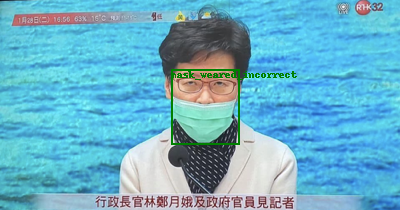

301x400


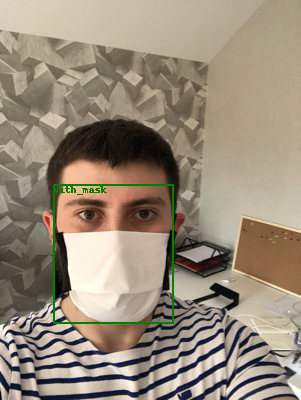

267x400


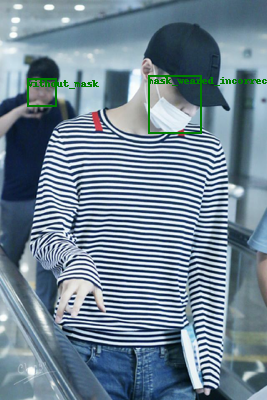

In [ ]:
# pick one image from the train set
img, target = dataset_train[0]
draw_bounding_boxes(img, target)

img, target = dataset_train[4]
draw_bounding_boxes(img, target)

img, target = dataset_train[7]
draw_bounding_boxes(img, target)

### Setting up the Faster R-CNN Model

In [ ]:
# Setting up GPU device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Nº of classes: background, with_mask, mask_weared_incorrect, without_mask and build model (faster r-cnn)
num_classes = 4 
model = build_model(num_classes)

model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
# Set Hyper-parameters

# Network params
params = [p for p in model.parameters() if p.requires_grad]

# Optimizers
optimizer = torch.optim.Adam(params, lr=0.0001)
#optimizer = torch.optim.SGD(params, lr=0.005)

# Learning Rate, lr decreases to half every 2 epochs 
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Number of epochs to perform
epochs=20


### Train the model

In [ ]:
pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/gautamchitnis/cocoapi.git (to revision cocodataset-master) to /tmp/pip-req-build-wzji15jf
  Running command git clone -q https://github.com/gautamchitnis/cocoapi.git /tmp/pip-req-build-wzji15jf
  Running command git checkout -b cocodataset-master --track origin/cocodataset-master
  Switched to a new branch 'cocodataset-master'
  Branch 'cocodataset-master' set up to track remote branch 'cocodataset-master' from 'origin'.
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265320 sha256=3aba1e2d4e84d0edca62fc1d4cf960c07e7dea2d21a5d64744e0b3e85b3a9796
  Stored in directory: /tmp/pip-ephem-wheel-cache-vs71d2py/wheels/6e/c9/59/56484d4d5ac1ab292a452b4c3870277256551505954fc4a1db
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.

In [ ]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../
%cd ..

Cloning into 'vision'...
remote: Enumerating objects: 190176, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 190176 (delta 11), reused 12 (delta 7), pack-reused 190143
Receiving objects: 100% (190176/190176), 375.91 MiB | 20.46 MiB/s, done.
Resolving deltas: 100% (170946/170946), done.
/content/vision
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version
/content


In [ ]:
from engine import train_one_epoch
# Training
for epoch in range(epochs):
    # train for one epoch, printing every 50 iterations
    train_one_epoch(model, optimizer, loader_train, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, loader_val, device=device)

Epoch: [0]  [  0/170]  eta: 0:02:57  lr: 0.000001  loss: 2.1042 (2.1042)  loss_classifier: 1.6616 (1.6616)  loss_box_reg: 0.0811 (0.0811)  loss_objectness: 0.2105 (0.2105)  loss_rpn_box_reg: 0.1509 (0.1509)  time: 1.0424  data: 0.1549  max mem: 1391
Epoch: [0]  [ 20/170]  eta: 0:01:06  lr: 0.000013  loss: 1.7572 (1.6751)  loss_classifier: 1.2356 (1.2573)  loss_box_reg: 0.1703 (0.1726)  loss_objectness: 0.1480 (0.1799)  loss_rpn_box_reg: 0.0220 (0.0654)  time: 0.4127  data: 0.1111  max mem: 2507
Epoch: [0]  [ 40/170]  eta: 0:00:55  lr: 0.000024  loss: 0.7379 (1.2276)  loss_classifier: 0.3061 (0.8143)  loss_box_reg: 0.3008 (0.2367)  loss_objectness: 0.0648 (0.1258)  loss_rpn_box_reg: 0.0233 (0.0508)  time: 0.4027  data: 0.1004  max mem: 2507
Epoch: [0]  [ 60/170]  eta: 0:00:45  lr: 0.000036  loss: 0.4773 (1.0015)  loss_classifier: 0.1737 (0.6075)  loss_box_reg: 0.2569 (0.2530)  loss_objectness: 0.0275 (0.0975)  loss_rpn_box_reg: 0.0105 (0.0435)  time: 0.4028  data: 0.1013  max mem: 2507


### Saving the Model

In [ ]:
from datetime import datetime
# Save model with current date
now = datetime.now()
d = now.strftime("%Y_%b_%d_%Hh_%mm")
PATH = 'model_'+d+'.pt'

In [ ]:
torch.save(model.state_dict(), PATH)

### Evaluate and Predict on Test Set


In [ ]:
# Get saved model
model_eval = model.load_state_dict(torch.load(PATH))

Evaluation:

In [ ]:
# put the model in evaluation mode
model.eval()

# Evaluate the model
evaluate(model, loader_test, device=device)

mAP:0.419
	AP at IoU level [0.50]: 0.645
	AP at IoU level [0.55]: 0.639
	AP at IoU level [0.60]: 0.629
	AP at IoU level [0.65]: 0.611
	AP at IoU level [0.70]: 0.566
	AP at IoU level [0.75]: 0.485
	AP at IoU level [0.80]: 0.370
	AP at IoU level [0.85]: 0.196
	AP at IoU level [0.90]: 0.044
	AP at IoU level [0.95]: 0.002


(0.41878714099522474,
 [0.6450177478928426,
  0.6389704014059845,
  0.629120241522798,
  0.6111861989017132,
  0.5657634863451461,
  0.48528152182043605,
  0.37007749023925945,
  0.19647219081539297,
  0.044251811806310576,
  0.0017303192023640987])

Test prediction on random image.

400x208


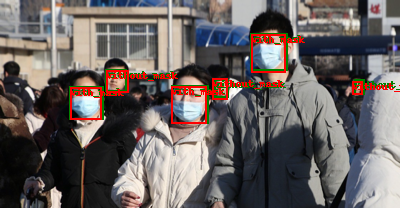

In [ ]:
# Make prediction on random image
n = randint(0, dataset_test.len)
img, target = dataset_test[n]
with torch.no_grad():
    prediction = model([img.to(device)])[0]

# Non max suppression to reduce the number of bounding boxes
nms_prediction = apply_nms(prediction, iou_thresh=0.5)
# Remove low score boxes below score_thresh
filtered_prediction = remove_low_score_bb(nms_prediction, score_thresh=0.3)

# Draw bounding boxes
draw_bounding_boxes(img.detach().cpu(), target=target, prediction=filtered_prediction)

Evaluation from coco tools


In [ ]:
from engine import evaluate as eval 
eval(model, loader_test, device=device)

creating index...
index created!
Test:  [ 0/38]  eta: 0:00:07  model_time: 0.1497 (0.1497)  evaluator_time: 0.0055 (0.0055)  time: 0.2033  data: 0.0461  max mem: 2795
Test:  [37/38]  eta: 0:00:00  model_time: 0.1278 (0.1290)  evaluator_time: 0.0088 (0.0208)  time: 0.2180  data: 0.0592  max mem: 2795
Test: Total time: 0:00:08 (0.2127 s / it)
Averaged stats: model_time: 0.1278 (0.1290)  evaluator_time: 0.0088 (0.0208)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.757
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=

# VGG19 Approach

## How to create a Deep Learning face mask classifier for COVID-19 in public spaces


### Introduction

The [CDC](https://www.cdc.gov/) continues to monitor the spread of COVID-19 and advises people who are completely vaccinated as well as those who are not fully vaccinated to wear face masks. When visiting the doctor's office, hospitals, or long-term care institutions, the CDC recommends wearing masks and keeping a safe distance. 

Manually monitoring people entering such institutions is tedious and requires workforce. In this tutorial, we will learn how we can automate this process through deep learning techniques which will automatically detect people not wearing masks to prevent their entry.


## Creating the mask detection deep learning model

We will now look into building a Deep Learning model to predict (detect) if a person is violating the rules by not wearing a mask in public spaces.

### Step 1: Importing the necessary Python libraries

In [ ]:
import numpy as np  # linear algebra
import cv2 # opencv
import matplotlib.pyplot as plt # image plotting
# keras
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

### Step 2: Getting the data

For the training data, we are using the face mask detection data from [here](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset). The dataset contains 12 thousand images divided into Test, Train, and Validation sets which were scraped from Google and the CelebFace dataset created by [Jessica Li ](https://www.kaggle.com/jessicali9530).

In [ ]:
# Load train and test set
train_dir = "/content/FaceMaskDetection12k/Train"
test_dir = "/content/FaceMaskDetection12k/Test"
val_dir = "/content/FaceMaskDetection12k/Validation"

### Step 3: Reading a sample image and performing face detection

We will now read in a sample image from a busy airport and perform face detection using haar cascade classifier. The [Haar cascade classifier](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html), originally known as the Viola-Jones Face Detection Technique is a object detection algorithm for detecting faces in images or real-time video. 

Viola and Jones proposed edge or line detection features in their research paper "Rapid Object Detection using a Boosted Cascade of Simple Features," published in 2001. The algorithm is given a large number of positive photos with faces and a large number of negative images with no faces. The model developed as a result of this training can be found in the OpenCV GitHub [repository](https://github.com/opencv/opencv/tree/master/data/haarcascades).

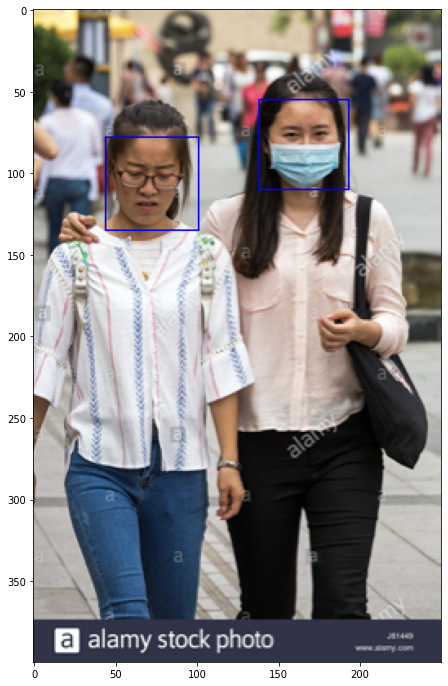

In [ ]:
# Read a sample image
img = cv2.imread("../input/face-mask-detection/images/maksssksksss352.png")

# Keep a copy of coloured image
orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# Convert image to grayscale
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# loading haarcascade_frontalface_default.xml
face_detection_model = cv2.CascadeClassifier("../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml")

# detect faces in the given image
return_faces = face_detection_model.detectMultiScale(
    img, scaleFactor=1.08, minNeighbors=4
)  # returns a list of (x,y,w,h) tuples

# plotting the returned values
for (x, y, w, h) in return_faces:
    cv2.rectangle(orig_img, (x, y), (x + w, y + h), (0, 0, 255), 1)

plt.figure(figsize=(12, 12))
plt.imshow(orig_img)  # display the image

### Step 4: Data preprocessing for building the mask detection Keras model

We will now pass our datasets into Keras [ImageDataGenerator()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to perform some preliminary data augmentation steps such as rescaling. 

In [ ]:
# Data preprocessing
# Train data
datagenerator = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2
)
train_generator = datagenerator.flow_from_directory(
    directory=train_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Validation data
val_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Test data
test_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Step 5: Create the mask detection transfer learning model using Keras

We are building the deep learning classifer using the VGG19 transfer learning model. The VGG19 model is the successor of AlexNet, a variation of the VGG model named after the group named as Visual Geometry Group at Oxford which created it. It is a deep CNN consisting of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer) used to classify images. 

It has been trained on [ImageNet](https://image-net.org/), a picture database with 14,197,122 images structured according to the WordNet hierarchy.

VGG19 Architecture


In [ ]:
# Initializing the VGG19 model
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

# Initialize a sequential model
model = Sequential()
model.add(vgg19_model)
model.add(Flatten())
model.add(Dense(2, activation="sigmoid"))
model.summary()

# Compiling the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


### Step 6: Train the model

We will now train our neural network model for 20 epochs.

In [ ]:
# Fit the model on train data along with validation data
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator) // 32,
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

Epoch 1/20


14:36:57.564987: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005

9/9 [==============================] - 11s 370ms/step - loss: 0.5636 - accuracy: 0.7465
Epoch 2/20
9/9 [==============================] - 3s 348ms/step - loss: 0.2521 - accuracy: 0.9167
Epoch 3/20
9/9 [==============================] - 3s 389ms/step - loss: 0.1610 - accuracy: 0.9444
Epoch 4/20
9/9 [==============================] - 3s 344ms/step - loss: 0.1345 - accuracy: 0.9514
Epoch 5/20
9/9 [==============================] - 3s 324ms/step - loss: 0.1158 - accuracy: 0.9688
Epoch 6/20
9/9 [==============================] - 3s 348ms/step - loss: 0.1159 - accuracy: 0.9618
Epoch 7/20
9/9 [==============================] - 3s 326ms/step - loss: 0.1098 - accuracy: 0.9722
Epoch 8/20
9/9 [==============================] - 3s 353ms/step - loss: 0.1017 - accuracy: 0.9688
Epoch 9/20
9/9 [==============================] - 3s 311ms/step - loss: 0.0774 - accuracy: 0.9757
Epoch 10/20
9/9 [==============================] - 3s 314ms/step - loss: 0.0698 - accuracy: 0.9826
Epoch 11/20
9/9 [============

### Step 7: Evaluate the model performance on test set

In [ ]:
# Evaluate model performance on test data
model_loss, model_acc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

25/25 [==============================] - 9s 350ms/step - loss: 0.0678 - accuracy: 0.9775
Model has a loss of 0.07 and accuracy 97.75%


### Step 8: Save the model

We can also choose to save the trained model as a h5 file for future use.

In [ ]:
model.save('data/saved_model.h5')

### Step 9: Test the model on the sample image

We will now test the trained model on our use case for detecting faces and masks for a group of people. We take the detected face crops of the faces detected in the image and then predict the mask or no mask using the model trained.

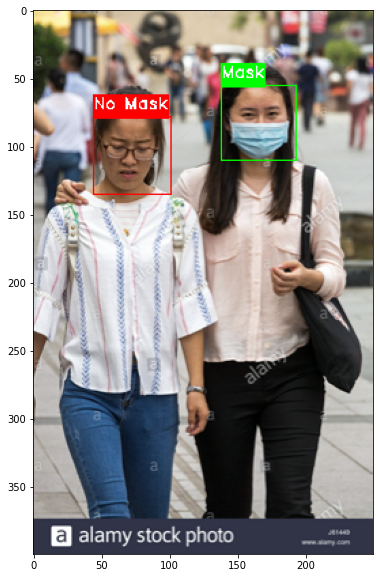

In [ ]:
# label for mask detection
mask_det_label = {0: "Mask", 1: "No Mask"}
mask_det_label_colour = {0: (0, 255, 0), 1: (255, 0, 0)}
pad_y = 1  # padding for result text

main_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# For detected faces in the image
for i in range(len(return_faces)):
    (x, y, w, h) = return_faces[i]
    cropped_face = main_img[y : y + h, x : x + w]
    cropped_face = cv2.resize(cropped_face, (128, 128))
    cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
    mask_result = model.predict(cropped_face)  # make model prediction
    print_label = mask_det_label[mask_result.argmax()] # get mask/no mask based on prediction
    label_colour = mask_det_label_colour[mask_result.argmax()] # green for mask, red for no mask

    # Print result
    (t_w, t_h), _ = cv2.getTextSize(
        print_label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1
    )  # getting the text size
    
    cv2.rectangle(
        main_img,
        (x, y + pad_y),
        (x + t_w, y - t_h - pad_y - 6),
        label_colour,
        -1,
    )  # draw rectangle

    cv2.putText(
        main_img,
        print_label,
        (x, y - 6),
        cv2.FONT_HERSHEY_DUPLEX,
        0.4,
        (255, 255, 255), # white
        1,
    )  # print text

    cv2.rectangle(
        main_img,
        (x, y),
        (x + w, y + h),
        label_colour,
        1,
    )  # draw bounding box on face

plt.figure(figsize=(10, 10))
plt.imshow(main_img)  # display image

We can see that the model is correctly detecting faces and classifying them as mask and no mask.
